In [1]:
import scipy as sp
import numpy as np
import BATT as b
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import fsolve
from scipy.integrate import solve_bvp

%matplotlib inline

In [17]:
# initializing constants
K = 0.06       #liquid conductivity
s = 20.        #solid conductivity
a = 23300.     #area/volume
ac = 0.5       #alpha cathode
aa = 0.5       #alpha anode
io = 2e-7      #exchange current density
L = 0.5        #length in cm
n = 1          #exchanged electrons
F = 96485      #Faraday's constant
R = 8.314      #gas constant
T = 298        #temperature
I = 0.1        #total current density
L_sep = 0.1    #length of separator
Resist_sep = 1 #resistance of separator per length

d = 5.03       #g/cm3 density of MnO2
MW = 86.9368   #molecular mass of MnO2
V = 12         #volume of the electrode in cm3, arbitrary choice
W = 50         #mass of electrode in g, arbitrary choice
ro = 0.003     #constant outer radius of cores
pi = 3.1415926 #π
D_H = 5e-6     #Approximate diffusivity of H+ through MgOOH
C_a = 0.6      #Surface concentration of OH, treated as constant for simplicity

coulomb_density = d/MW * F
N = (W/V)/((4/3*pi*ro**3)*d)


# Steady State Repost

In [18]:
Vwall1 = 1
Vwall2 = 1

def BCCath(ya, yb):
    return (yb[0] - I), (ya[1] - I), ya[3] - Vwall_2, yb[1]
#     return (ya[0] - I), yb[0], (yb[1] - I), ya[2]# (yb[4] - I), ya[4], (ya[5] - I), ya[2], (ya[6])

def BCAn(ya, yb):
    return (yb[1] - I), (ya[0] - I), yb[3], yb[0]
#     return (ya[0] - I), yb[0], (yb[1] - I), ya[2]# (yb[4] - I), ya[4], (ya[5] - I), ya[2], (ya[6])
      
def TafelCath(x, IV):
    """
    uses Tafel kinetics
    """
    is_p, ie_p, Vs_p, Ve_p = IV
    #n represents anode attributes, p represents cathode attributes
    
    taff_p = -ac*n*F/(R*T)*(Vs_p - Ve_p)
    die_p = -a*io*np.exp(taff_p)
    #Kinetics
    
    dis_p = -die_p
    #charge neutrality
    
    dVs_p = -is_p/s
    #solids ohms law
    
    dVe_p = -ie_p/K
    #liquids ohms law

    return dis_p, die_p, dVs_p, dVe_p

def TafelAn(x, IV):
    """
    uses Tafel kinetics
    """
    
    is_n, ie_n, Vs_n, Ve_n = IV
    #n represents anode attributes, p represents cathode attributes
    
    taff_n = aa*n*F/(R*T)*(Vs_n - Ve_n)
    die_n = a*io*np.exp(taff_n)
    #Kinetics
    
    dis_n = -die_n
    #charge neutrality
    
    dVs_n = -is_n/s
    #solids ohms law
    
    dVe_n = -ie_n/K
    #liquids ohms law

    return dis_n, die_n, dVs_n, dVe_n

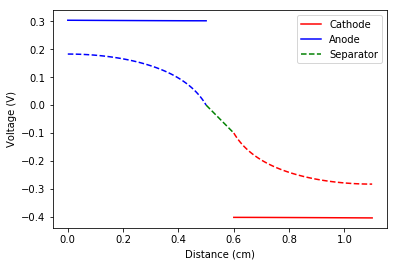

In [46]:
N = 10
N_sep = 20
x_cath = np.linspace(L + L_sep, 2*L + L_sep, N)
x_an = np.linspace(0, L, N)
y = np.zeros([4, N])

x_plot_cath = np.linspace(L + L_sep, L_sep + 2*L, 100)
x_plot_an = np.linspace(0, L, 100)

An = solve_bvp(TafelAn, BCAn, x_an, y)
Vwall_1 = An.sol(x_plot_an)[3][-1]

x_sep = np.linspace(L, L + L_sep, N_sep)
is_sep = np.ones(N_sep) * An.sol(x_plot_an)[0][-1]
ie_sep = np.ones(N_sep) * An.sol(x_plot_an)[1][-1]
Ve_sep = np.zeros(N_sep)
Ve_sep[0] = Vwall_1
for i in range(N_sep):
    Ve_sep[i] = Vwall_1 - (x_sep[i] - L) * Resist_sep

Vwall_2 = Ve_sep[-1]
Cath = solve_bvp(TafelCath, BCCath, x_cath, y)
# Ta_IV = solve_bvp(Tafelfunc_a, BC_a, x, y)
# Tc_IV = solve_bvp(Tafelfunc_c, BC_c, x, y)

for i in range(2,4):
    if i == 2:
        label1 = 'Cathode'
        label2 = 'Anode'
        linesty = '-'
    else:
        label1 = None
        label2 = None
        linesty = '--'
    plt.plot(x_plot_cath, Cath.sol(x_plot_cath)[i], color = 'r', label = label1, linestyle = linesty)
    plt.plot(x_plot_an, An.sol(x_plot_an)[i], color = 'b', label = label2, linestyle = linesty)

plt.plot(x_sep, Ve_sep, color = 'g', label = 'Separator', linestyle = '--')
# plt.plot(x_sep, ie_sep, color = 'g', linestyle='--')
# plt.plot(x_sep, is_sep, color = 'g', label = 'Separator')
plt.legend(loc = 'best')
plt.xlabel('Distance (cm)')
plt.ylabel('Voltage (V)')
plt.savefig('SS_Voltage_full.png')

# Non-Steady State

In [20]:
def USS_TafelAn(x, IV):
    """
    uses Tafel kinetics
    """
    
    is_n, ie_n, Vs_n, Ve_n = IV
    #n represents anode attributes, p represents cathode attributes
    
    x_data = i_lim_x.copy() #np.linspace(0, L, 10)
    y_data = i_lim.copy()   #np.array([1,1,1,1,1,1,1,1,1,1])
    # copies in limiting current from outside the function


    f = sp.interpolate.interp1d(x_data, y_data) 
    die_n_lim = f(x)
    #creates a continuous function callable by solve_bvp
    
    taff_n = aa*n*F/(R*T)*(Vs_n - Ve_n)
    taff_c = -ac*n*F/(R*T)*(Vs_n - Ve_n)
    die_n = (np.exp(taff_n)-np.exp(taff_c))/(1/(a*io)+(np.exp(taff_n)-np.exp(taff_c))/die_n_lim)
    #Kinetics
    
    dis_n = -die_n
    #charge neutrality
    
    dVs_n = -is_n/s
    #solids ohms law
    
    dVe_n = -ie_n/K
    #liquids ohms law

    return dis_n, die_n, dVs_n, dVe_n

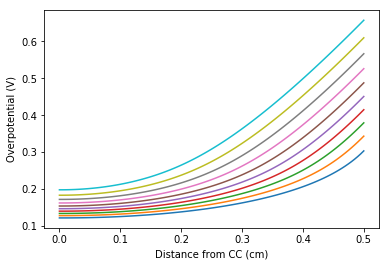

In [64]:
N = 10
N_sep = 20
x_cath = np.linspace(L + L_sep, 2*L + L_sep, N)
x_an = np.linspace(0, L, N)
y = np.zeros([4, N])
i_lim_x = np.linspace(0,L,100)
r_i = np.ones(i_lim_x.size) * 0.00299
i_lim = 4*pi*F*N*D_H*C_a/(1/r_i - 1/ro)

# x_plot_cath = np.linspace(L + L_sep, L_sep + 2*L, 1000)
x_plot_an = np.linspace(0, L, 1000)

# An = solve_bvp(USS_TafelAn, BCAn, x_an, y)
fig = plt.figure()
for j in range(185):
    
    An = solve_bvp(USS_TafelAn, BCAn, x_an, y) #An[0] = is_n, An[1] = ie_n, An[2] = Vs_n, An[3] = Ve_n
    IV = An.sol(i_lim_x)
    #Solves the boundary value problem and sets solutions to IV
    
    taff_n = aa*n*F/(R*T)*(IV[2] - IV[3])
    taff_c = -ac*n*F/(R*T)*(IV[2] - IV[3])
    i_F = (np.exp(taff_n)-np.exp(taff_c))/(1/(a*io)+(np.exp(taff_n)-np.exp(taff_c))/i_lim)
    #uses kinetic solution of current iteration to determine faradaic current
    
    r_i = r_i - i_F/(coulomb_density*4*pi*r_i**2) * 0.00001 
    #timestep the inner radius
    
    i_lim = 4*pi*F*N*D_H*C_a/(1/r_i - 1/ro) 
    #Creates next iteration's limiting current
    
    
    if j % 20 == 0:
#         for n in range(2,4):
#             plt.plot(x_plot_an, An.sol(x_plot_an)[n], color = 'b', label = 'anode')

#         plt.plot(i_lim_x, r_i)
        plt.plot(i_lim_x, IV[2] - IV[3])
plt.xlabel('Distance from CC (cm)')
plt.ylabel('Overpotential (V)')
plt.savefig('Overpotential.png')
#     print(i_lim)

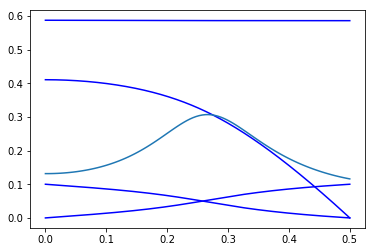

In [8]:
for j in range(4):
    plt.plot(x_plot_an, An.sol(x_plot_an)[j], color = 'b', label = 'anode')

plt.plot(i_lim_x, i_F)
# plt.plot(i_lim_x, i_lim)

In [9]:
# An = solve_bvp(USS_TafelAn, BCAn, x_an, y) #An[0] = is_n, An[1] = ie_n, An[2] = Vs_n, An[3] = Ve_n
# IV = An.sol(i_lim_x)

# taff_n = aa*n*F/(R*T)*(IV[2] - IV[3])
# taff_c = -ac*n*F/(R*T)*(IV[2] - IV[3])
# die_n = (np.exp(taff_n)-np.exp(taff_c))/(1/(a*io)+(np.exp(taff_n)-np.exp(taff_c))/i_lim) 

i_lim = i_lim + die_n * .01

NameError: name 'die_n' is not defined

In [ ]:
print(IV[2] - IV[3], taff_n, taff_c, np.exp(taff_n), np.exp(taff_c), die_n)

In [ ]:
i_lim_x = np.linspace(0,L,100)
i_lim = np.ones(i_lim_x.size)
An = solve_bvp(USS_TafelAn, BCAn, x_an, y)

IV = An.sol(i_lim_x)
    
taff_n = aa*n*F/(R*T)*(IV[2] - IV[3])
taff_c = -ac*n*F/(R*T)*(IV[2] - IV[3])
die_n = (np.exp(taff_n)-np.exp(taff_c))/(1/(a*io)+(np.exp(taff_n)-np.exp(taff_c))/i_lim) 
    
for i in range(4):
    plt.plot(x_plot_an, An.sol(x_plot_an)[i], color = 'b', label = 'anode')
plt.plot(i_lim_x, die_n)
#plt.plot(i_lim_x, zprime)

In [ ]:
print(aa*n*F/R/T)

In [ ]:
plt.plot(i_lim_x, IV[2] - IV[3])

In [ ]:
np.concatenate(([0,1], [0,1]))